In [101]:
#######################################################################
#                     REQUIRED DEPENDENCIES                           #
#                  Recommended: Cygwin for Windows                    #
#                                                                     #
#                      'pip install PyPDF2'                           #
#                      'pip install pdf2image'                        # 
#                      'pip install pillow'                           #
#                      'pip install pandas'                           # 
#                      'pip install matplotlib'                       #
#                      'pip install scipy'                            #
#                      'pip install numpy'                            #
#         'https://imagemagick.org/script/download.php#windows'       # 
#                                                                     # 
#   Note: I think an image manipulation program called ghost?         #
#         is needed, but I forgot where to download it                #
#         so if you are thrown an error the reason should be on s.o   #
#         S.L 8/23/19                                                 #
#                                                                     #
#                       Style Guide                                   #
#                      -Name                                          #
#                      -Purpose                                       #
#                      -Inputs                                        #
#                      -Outputs                                       #
#                      -Date Last Modified                            # 
#                                                                     # 
#             _/\_/\_camelCase Function Names _/\_/\_                 #
#######################################################################

import PyPDF2 # Used to read in PDF files  
from PyPDF2 import PdfFileReader, PdfFileWriter
from pdf2image import convert_from_path # might be legacy code, unsure
import PIL # PNG image manipulation                  
from PIL import Image, ImageFilter
from wand.image import Image as Img # Used for manipulating PNG images,
                                    # NOTE: Must match python distribution, not windows.
                                    # i.e. python x32 with wand x32
import os # directory manipulation
import os.path
from PIL import Image
import pandas as pd # dataframe manipulation
import sys
import scipy.misc # numpy array manipulation
import matplotlib.pyplot as plt # numpy array manipulation                
from scipy.misc import imresize

#import pyocr
#import pyocr.builders
#import subprocess
#tools = pyocr.get_available_tools()[0]
#langs = tools.get_available_languages()
#lang = langs[0]

In [52]:
########################################################################################
#                                                                                      #
# Name: newGetAnswers                                                                  #
#                                                                                      # 
# Purpose: loops through pdf pages from scanned pdf packet to call rest of program     #
#                                                                                      #
# Inputs:  string (pdfPacketName)                                                      #
#                                                                                      # 
# Outputs: Nothing                                                                     #
#                                                                                      #  
#                                                                                      #  
# Date Last modified: S.L. 7/18/19                                                     # 
########################################################################################

def newGetAnswers(pdfPacketName):
    
    worksheetName = "Koa-CA-1"
    
    sheet_id = []; name_id = []
    pdfFileObj = open(pdfPacketName, 'rb') 
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    #print(pdfReader.numPages)
    pageCounter = 0
        
    for i in range(pdfReader.numPages):
        
        #print("PageCounter = " + str(pageCounter))
        
        pageObj = pdfReader.getPage(i)

        if not os.path.exists(worksheetName):
            os.makedirs(worksheetName)
        
        #pathName = "tempDir/" + "page" + pageCounter + "_answer" + answerCounter
        pathName = worksheetName + "/worksheet" + str(pageCounter)
        if not os.path.exists(pathName):
            os.makedirs(pathName)
    
        df = pd.read_csv('points.csv')
        worksheetName = "Koa-CA-1"

        #df['Koa-CA-1'].str.split(';')
        #for row in df.itertuples(index=True, name='Pandas'):
        #    print getattr(row, "c1"), getattr(row, "c2")
        #print(df)
        matrix = [list(l) for l in zip(*df.values)]

        getAttribute(pageObj, pathName, worksheetName, matrix, pdfPacketName)
         
        pageCounter += 1
        
    pdfFileObj.close()

In [53]:
########################################################################################
#                                                                                      #
# Name: pdfToPNG                                                                       #
#                                                                                      #
# Purpose: crops pdf files at specified location and converts them to png              #
#                                                                                      #
# Inputs: - pdf page object                                                            #
#         - string (image output name)                                                 #
#         - tuple (bottom left coordinate (x,y))                                       #
#         - tuple (upper right coordinate (x,y))                                       #
#                                                                                      #
# Outputs: Nothing                                                                     #
#                                                                                      #
#                                                                                      #
# Date Last modified: S.L. 7/18/19                                                     #
########################################################################################

def pdfToPNG(pageObj, fileName, bottomLeft, upperRight):

    writer = PdfFileWriter()

    pageObj.cropBox.lowerLeft = bottomLeft
    pageObj.cropBox.upperRight = upperRight

    writer.addPage(pageObj)
    outstream = open(fileName + ".pdf", 'wb')
    writer.write(outstream)
    outstream.close()
    with Img(filename= fileName + ".pdf", resolution=300) as img:   # convert pdf to jpg
        img.compression_quality = 99 
        img.save(filename= fileName + ".png")
    img = Image.open(fileName + '.png')
    crop_img = img.crop((bottomLeft[0] / 72 * 300, (11 - (upperRight[1] / 72)) * 300, upperRight[0] / 72 * 300, (11 - (bottomLeft[1] / 72)) * 300))
    crop_img.save(fileName + '.png')
    os.remove(fileName + ".pdf")
    
    resizeAndExport(fileName + '.png', fileName)
    
    
    #img = Image.open(fileName + ".png")
    #img = img.convert('L')
    #img = img.crop
    #img.save(fileName + ".png")

In [97]:
########################################################################################
#                                                                                      #
# Name: getAttribute                                                                   #
#                                                                                      #
# Purpose: getAttribute takes in a pageobject, pathname, and a dataframe               #
#          and writes the individual student answers in the corresponding              #
#          directory. Note: reliability depends on reading the correct                 #
#          worksheet name and student ID.                                              #
#                                                                                      #
# Inputs: -pdf page object                                                             #
#         -image pathname                                                              #
#         -worksheet identifier                                                        #
#         -matrix of points to get                                                     #
#         -the scanned packet name                                                     #
#                                                                                      #
# Outputs: Nothing                                                                     #
#                                                                                      #
# Date Last modified: S.L. 8/23/19                                                     #
########################################################################################

def getAttribute(pageObj, pathName, worksheetName, matrix, pdfPacketName):
    
    # Specify number of questions and parts for naming schema
    questions = 5
    partsList = [3,3,3,3,3]
    partNumber = 1   
    questionIndex = 0
    df = pd.read_csv('points.csv')
    
    matrix = [list(l) for l in zip(*df.values)] # read in points from points csv
    try: 
        pointsList = df[worksheetName]
    except:
        # legacy code
        print("Error: The CSV file does not contain points that correspond to the worksheet name - " + worksheetName)
        print("This can occur when the program misreads the worksheet name from the PDF file.")
        print("Note - This error means that an invalid directory has also been created in the top level.")
        pathName = input("""Please enter the correct pathname in the format \(Worksheet Name\/Student Name if known\), or
        type 'quit' to stop the kernel""")
        
        if pathName == 'quit':
            close(pdfPacketName)
            sys.exit(1)
        else:
            if not os.path.exists(pathName):
                os.makedirs(pathName)
            worksheetName = pathName.split("/")[0]         
            pointsList = df[worksheetName]
    for i in range(len(pointsList)):
        if partNumber >= partsList[questionIndex] + 1:
            partNumber = 1
            questionIndex += 1
        bottomLeft = getCorner(pointsList[i])
        #print(bottomLeft)
        topRight = getSides(bottomLeft, pointsList[i])
        #print(pathName + "/" + str(partNumber))
        pdfToPNG(pageObj, pathName + "/question" + str(questionIndex + 1) + "_part" + str(partNumber), bottomLeft, topRight,)
        partNumber += 1

In [78]:
########################################################################################
#                                                                                      #
# Name: getCorner                                                                      #
#                                                                                      #
# Purpose: returns bottom left corner coordinate from the points csv file              #
#                                                                                      #
# Inputs: -string (read in from user specified points file defined in getAttribute)    #
#                                                                                      #
# Outputs: -a tuple representing pixel location (x, y)                                 #
#                                                                                      #
#                                                                                      #
# Date Last modified: S.L. 7/18/19                                                     #
########################################################################################

def getCorner(string): 
    #print(string[3:19])
    bl = string.split("; size-")[0].split("BL-")[1].split(",")
    return (((float(bl[0][1:]))) * 72, (11 - float(bl[1][:len(bl[1]) - 1])) * 72)

In [79]:
########################################################################################
#                                                                                      #
# Name: getSides                                                                       #
#                                                                                      #
# Purpose: returns the x and y length of image box from points csv file                #
#                                                                                      #
# Inputs: string (read in from user specified points file defined in getAttribute)     #
#                                                                                      #
# Outputs: a tuple representing side lengths (x, y)                                    #
#                                                                                      #
#                                                                                      #
# Date Last modified: S.L. 7/19/19                                                     #
########################################################################################

def getSides(bottomLeft, string):
    string = string.split("; size-")[1].split(",")
    #print(string)
    return((bottomLeft[0] + 72 * float(string[0][1:])), (bottomLeft[1] + 72 * float(string[1][:len(string[1]) - 1])))

In [82]:
########################################################################################
#                                                                                      #
# Name: imcrop_tosquare                                                                #
#                                                                                      #
# Purpose: reads in a numpy n-dimension array and returns it as a cropped square image #
#                                                                                      #
# Inputs: np.ndarray (assumed at least 2d)                                             #
#                                                                                      #
# Outputs: np.ndarray (cropped image)                                                  #
#                                                                                      #
#                                                                                      #
# Date Last modified: S.L. 8/23/19                                                     #
########################################################################################

def imcrop_tosquare(img):
    if img.shape[0] > img.shape[1]:
        extra = (img.shape[0] - img.shape[1])
        if extra % 2 == 0:
            crop = img[extra // 2:-extra // 2, :]
        else:
            crop = img[max(0, extra // 2 + 1):min(-1, -(extra // 2)), :]
    elif img.shape[1] > img.shape[0]:
        extra = (img.shape[1] - img.shape[0])
        if extra % 2 == 0:
            crop = img[:, extra // 2:-extra // 2]
        else:
            crop = img[:, max(0, extra // 2 + 1):min(-1, -(extra // 2))]
    else:
        crop = img
    return crop

In [83]:
########################################################################################
#                                                                                      #
# Name: imcrop                                                                         #
#                                                                                      #
# Purpose: reads in an image a numpy n-dimensional array and                           #
#          crops it by an arbitrary factor (0 - 1)                                     #
#                                                                                      #
# Inputs: np.ndarray (image)                                                           #
#                                                                                      #
# Outputs: np.ndarray (cropped image)                                                  #
#                                                                                      #
# Additional Notes: Might not be necessary, additional testing should be done          #
# Date Last modified: S.L. 8/23/19                                                     #
########################################################################################

def imcrop(img, amt):
    if amt <= 0 or amt >= 1:
        return img
    row_i = int(img.shape[0] * amt) // 2
    col_i = int(img.shape[1] * amt) // 2
    return img[row_i:-row_i, col_i:-col_i]

In [84]:
########################################################################################
#                                                                                      #
# Name: getLabelName                                                                   #
#                                                                                      #
# Purpose: converts image filepath into a label that will be exported to the csv       #
#                                                                                      #
# Inputs: string (filepath of an image)                                                #
#                                                                                      #
# Outputs: string (image label)                                                        #
#                                                                                      #
# Date Last modified: S.L. 8/23/19                                                     #
#                                                                                      #
########################################################################################

def getLabelName(filePath):
    # tempDir/worksheet0/q_0
    directoryList = filePath.split('/')
    
    return directoryList[1] + "_" + directoryList[2]

In [92]:
########################################################################################
#                                                                                      #
# Name: resizeAndExport                                                                #
#                                                                                      #
# Purpose: uses image name to 1) open an image                                         #
#                             2) resize image to 28 x 28                               #
#                             3) export image pixel intensities to a csv               #
#                                                                                      #
# Inputs: string string                                                                #
#                                                                                      #
# Outputs: Nothing                                                                     #
#                                                                                      #
#                                                                                      #
# Date Last modified: S.L. 8/23/19                                                     #                                                                                 #
########################################################################################

def resizeAndExport(imageName, headerName):
    
    label = getLabelName(headerName) 
    print(label) # helps show user progress of program
    plt.axis('off')
    img = plt.imread(imageName)
    square = imcrop_tosquare(img)
    crop = imcrop(square, 0.2)
    rsz = imresize(crop, (28, 28))
    intensity = rsz.sum(axis=2) // 4 # gets the average intensity from (R,G,B,A) values of pixel
    #plt.imshow(intensity)
    intensity = intensity.flatten()  # flatten to 1-D array
    
    # Reshapes 1-D numpy array so that each value is read in column-wise instead of row-wise
    df1 = pd.DataFrame(intensity.reshape(-1, len(intensity)),columns= range(0, len(intensity)))
    df2 = pd.DataFrame({"label" : [label]})
    df1 = df1.join(df2)
    
    # output to csv with label
    df1.to_csv('test.csv', mode= 'a', header=False, index = False)

worksheet0_question1_part1


`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead. [ipykernel_launcher.py:10]


worksheet0_question1_part2
worksheet0_question1_part3
worksheet0_question2_part1
worksheet0_question2_part2
worksheet0_question2_part3
worksheet0_question3_part1
worksheet0_question3_part2
worksheet0_question3_part3
worksheet0_question4_part1
worksheet0_question4_part2
worksheet0_question4_part3
worksheet0_question5_part1
worksheet0_question5_part2
worksheet0_question5_part3
worksheet1_question1_part1
worksheet1_question1_part2
worksheet1_question1_part3
worksheet1_question2_part1
worksheet1_question2_part2
worksheet1_question2_part3
worksheet1_question3_part1
worksheet1_question3_part2
worksheet1_question3_part3
worksheet1_question4_part1
worksheet1_question4_part2
worksheet1_question4_part3
worksheet1_question5_part1
worksheet1_question5_part2
worksheet1_question5_part3
worksheet2_question1_part1
worksheet2_question1_part2
worksheet2_question1_part3
worksheet2_question2_part1
worksheet2_question2_part2
worksheet2_question2_part3
worksheet2_question3_part1
worksheet2_question3_part2
w

worksheet19_question5_part3
worksheet20_question1_part1
worksheet20_question1_part2
worksheet20_question1_part3
worksheet20_question2_part1
worksheet20_question2_part2
worksheet20_question2_part3
worksheet20_question3_part1
worksheet20_question3_part2
worksheet20_question3_part3
worksheet20_question4_part1
worksheet20_question4_part2
worksheet20_question4_part3
worksheet20_question5_part1
worksheet20_question5_part2
worksheet20_question5_part3
worksheet21_question1_part1
worksheet21_question1_part2
worksheet21_question1_part3
worksheet21_question2_part1
worksheet21_question2_part2
worksheet21_question2_part3
worksheet21_question3_part1
worksheet21_question3_part2
worksheet21_question3_part3
worksheet21_question4_part1
worksheet21_question4_part2
worksheet21_question4_part3
worksheet21_question5_part1
worksheet21_question5_part2
worksheet21_question5_part3
worksheet22_question1_part1
worksheet22_question1_part2
worksheet22_question1_part3
worksheet22_question2_part1
worksheet22_question

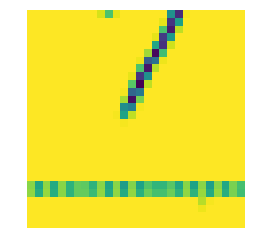

In [100]:
# launch program with pdf packet name
newGetAnswers("filled_koa-ca-1.pdf")

In [99]:
# uncomment to clear csv file
#
f= open('test.csv', 'w')
f.close()

In [ ]:
################# Legacy code because I have attachment issues#######################

In [ ]:
###############################################################################
# Main logic for making directories of student answers
# The code takes in the packet of scanned answers and then 
# sorts the worksheets based on worksheet name and student name
#
# Student answers are then placed into their own subdirectory
###############################################################################

def getAnswers(pdfPacketName):
    
    sheet_id = []; name_id = []
    pdfFileObj = open(pdfPacketName, 'rb') 
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    print(pdfReader.numPages)
        
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)

        pdfToPNG(pageObj, "identifier", (29, 740), (31 + 65, 745 + 26))
        
        
        ###############################################################################
        # This line of code processes the worksheet name
        # It takes the PNG rectangle box, lightens the 
        # rectangle box around the sheet name, and then 
        # darkens the actual characters
        # S.L. 7/18/19
        ###############################################################################
        bashCommand = """convert identifier.png -type Grayscale -negate -define morphology:compose=darken -morphology Thinning 'Rectangle:1x80+0+0<' -negate out.png""" # output file
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        ###############################################################################

        worksheetName = tools.image_to_string(Image.open('identifier.png'), 
                                     builder=pyocr.builders.DigitBuilder())

        # Create worksheet directory if it doesn't exist
        if not os.path.exists(worksheetName):
            os.makedirs(worksheetName)
            
        pageObj = pdfReader.getPage(i)
        writer = PdfFileWriter()
        
        pdfToPNG(pageObj, "student", (200, 739), (282, 775))

        studentName = tools.image_to_string(Image.open('student.png'), 
                                     builder=pyocr.builders.DigitBuilder())
        print(studentName)
        name_id.append(studentName)
        sheet_id.append(worksheetName)
        pathName = worksheetName + "/" + studentName
        print(pathName)

        if not os.path.exists(pathName):
            os.makedirs(pathName)

        df = pd.read_csv('points.csv')

        #df['Koa-CA-1'].str.split(';')
        #for row in df.itertuples(index=True, name='Pandas'):
        #    print getattr(row, "c1"), getattr(row, "c2")
        #print(df)
        matrix = [list(l) for l in zip(*df.values)]

        getAttribute(pageObj, pathName, worksheetName, matrix, pdfPacketName)
    pdfFileObj.close()

